# Bayesian prediction of Brownian particle motion

Procedure for generating the trajectories of Brownian particle is based on the [Nature paper](nature.com/articles/s41567-020-1018-2) are the authors' code.

In [1]:
from typing import Optional, List, Iterable
import functools
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import MSELoss

In [2]:
from brownian_datagen import BrownianDatagen
from bayesian import posterior_predictive_forward_and_backward, ExperimentResults, BayesTrainData, plot_predictions

In [3]:
brownian = BrownianDatagen()
save_dir = "20230724_preds/brownian01/"

In [4]:
def create_dataholder_for_windows_and_targets(brownian: BrownianDatagen,
                                              numParticles: int = 50,
                                              window_len: int = 3,
                                              rng_seed: Optional[int] = None) -> BayesTrainData:
    meaningless_time_series = np.zeros((5, 1), np.float32)
    dt = BayesTrainData(meaningless_time_series)
    # For Brownian motion, different windows might come from different
    # trajectories, so having one single time series doesn't make sense.
    # Morover, backward and forward don't refer to the same thing anymore:
    # they are generated separately, rather than backward = np.flip(forward).
    # But I want to keep using the same class for holding the train data, so I set attributes manually.
    generate_windows_targets = functools.partial(brownian.windows_targets, window_len=window_len, numParticles=numParticles)
    if rng_seed is not None:
        generate_windows_targets = functools.partial(generate_windows_targets, rng_seed=rng_seed)
    
    dt.windows_f, dt.targets_f = generate_windows_targets()
    dt.windows_b, dt.targets_b = generate_windows_targets(backward=True)
    dt.windows_f, dt.targets_f, dt.windows_b, dt.targets_b = map(
        lambda x: torch.tensor(x, dtype=torch.float32),
        (dt.windows_f, dt.targets_f, dt.windows_b, dt.targets_b))
    return dt

dt = create_dataholder_for_windows_and_targets(brownian, rng_seed=42)
print(dt.windows_f.shape, dt.targets_f.shape)

torch.Size([4850, 3]) torch.Size([4850, 1])


In [5]:
if not os.path.isdir(save_dir):
    posterior_predictive_forward_and_backward(dt, save_dir=save_dir, num_samples=100)
else:
    print("Directory exists, assuming the previous results are reusable")

Directory exists, assuming the previous results are reusable


In [6]:
!ls $save_dir

noisy_ts.torch		   targets_b.torch  windows_b.torch
predictive.backward.torch  targets_f.torch  windows_f.torch
predictive.forward.torch   ts.torch


In [7]:
er = ExperimentResults(save_dir)
print("forward MSE", MSELoss()(er.pred_obs_f.mean(axis=0), er.targets_f))
print("backward MSE", MSELoss()(er.pred_obs_b.mean(axis=0), er.targets_b))

forward MSE tensor(0.0002)
backward MSE tensor(0.0002)


In [8]:
dt_test = create_dataholder_for_windows_and_targets(brownian, numParticles=1, window_len=3, rng_seed=188)
print("test forward MSE", MSELoss()(er.predictive_f(dt_test.windows_f)["obs"].mean(axis=0), dt_test.targets_f))
print("test backward MSE", MSELoss()(er.predictive_b(dt_test.windows_b)["obs"].mean(axis=0), dt_test.targets_b))

test forward MSE tensor(0.0002)
test backward MSE tensor(0.0001)


In [9]:
print("forward average std:", er.predictive_f(dt_test.windows_f)["obs"].std(axis=0).mean())
print("backward average std:", er.predictive_b(dt_test.windows_b)["obs"].std(axis=0).mean())

forward average std: tensor(0.0141)
backward average std: tensor(0.0138)


torch.Size([97]) torch.Size([97])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Forward'}, xlabel='index', ylabel='target value'>)

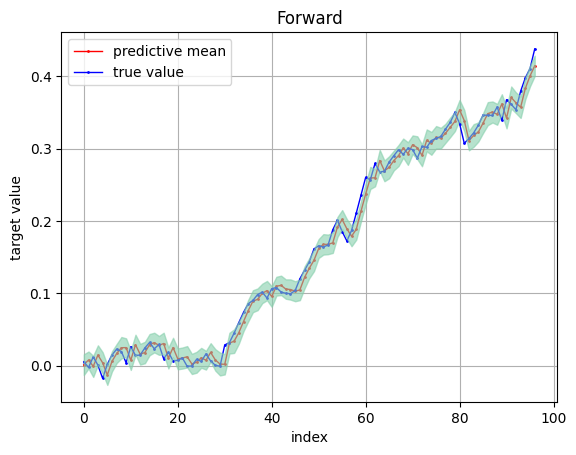

In [10]:
plot_predictions(true=dt_test.targets_f,
                 pred_mean=er.predictive_f(dt_test.windows_f)["obs"].mean(axis=0),
                 pred_std=er.predictive_f(dt_test.windows_f)["obs"].std(axis=0),
                 title="Forward")

torch.Size([97]) torch.Size([97])


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Backward'}, xlabel='index', ylabel='target value'>)

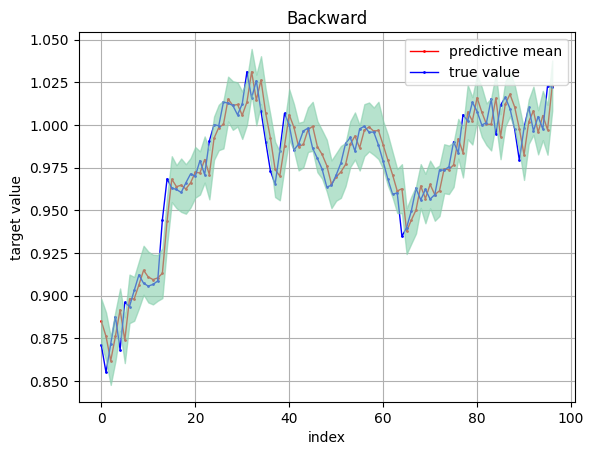

In [11]:
plot_predictions(true=dt_test.targets_b,
                 pred_mean=er.predictive_b(dt_test.windows_b)["obs"].mean(axis=0),
                 pred_std=er.predictive_b(dt_test.windows_b)["obs"].std(axis=0),
                 title="Backward")